In [36]:
%matplotlib inline

In [47]:
import pandas as pd # Manejo de datos tabulados
import numpy as np # Algebra Lineal y operaciones matematicas
import matplotlib.pyplot as plt # Graficos de datos
import seaborn as sns # Graficos estadisticos
import pandas_profiling as ppr # ?????????
from fitter import Fitter # Ajuste de distribuciones de probs

In [ ]:
sns.set_theme(style="whitegrid")

In [39]:
# Leemos los datos seleccionados
df_main = pd.read_csv('../data/TB_HOSP_VAC_FALLECIDOS.csv')
df_oxigen = pd.read_csv('../data/Oxigeno_25-10-2021.csv', sep="|")
df_camas = pd.read_csv('../data/Camas-08_03_2022.csv', sep="|")

In [40]:
# Validar integridad del identificador "único"
len(df_main['id_persona'].unique()), df_main.shape[0]

In [42]:
# Nulos en id_persona
df_main['id_persona'].isna().sum()

0

In [43]:
# Conteo de cuantas veces se duplican los id_persona
filtro_duplicados = df_main['id_persona'].duplicated(keep=False)
df_main[filtro_duplicados]['id_persona'].value_counts().head()

26422634    3
6054506     3
29048330    3
3820273     2
9985143     2
Name: id_persona, dtype: int64

In [44]:
# TODO: Crear variable si fue reinfeccion (0, 1)
# TODO: Crear variable con el # de la reinfeccion (1, 2, etc)

In [45]:
# Numero de valores perdidos / missings
edad_na_count = df_main['edad'].isna().sum()
print(edad_na_count)
print(round(edad_na_count / df_main.shape[0] * 100, 2), '%')

7843
5.75 %


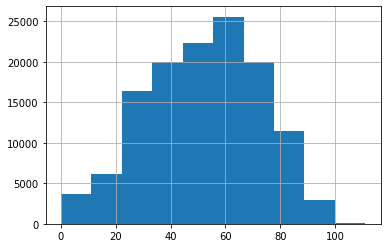

In [46]:
df_main['edad'].hist()
plt.show()

In [48]:
df_main['edad'].describe()

count    128579.000000
mean         52.179446
std          20.436026
min           0.000000
25%          37.000000
50%          54.000000
75%          68.000000
max         111.000000
Name: edad, dtype: float64

In [56]:
counts, bins = np.histogram(df_main['edad'].dropna().values, bins=7)
bins

array([  0.        ,  15.85714286,  31.71428571,  47.57142857,
        63.42857143,  79.28571429,  95.14285714, 111.        ])

In [71]:
edad_bins = pd.cut(df_main['edad'], bins=[0, 5, 13, 18, 25, 40, 55, 65, 80, 95, 112])

edad_bins_count = edad_bins.value_counts()

In [72]:
edad_bins_count

(40, 55]     29595
(65, 80]     26201
(25, 40]     25404
(55, 65]     23376
(80, 95]      9954
(18, 25]      7492
(5, 13]       2197
(13, 18]      1938
(0, 5]        1926
(95, 112]      451
Name: edad, dtype: int64

<AxesSubplot:>

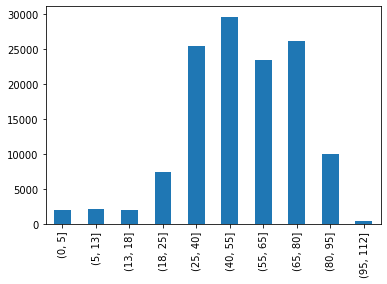

In [73]:
edad_bins_count.sort_index().plot(kind='bar')

In [82]:
df_main['edad_bins'] = edad_bins

In [77]:
# Valores perdidos / missings
df_main['sexo'].isna().sum(), df_main['sexo'].isna().sum() / df_main.shape[0]

(6840, 0.05013854070457844)

In [79]:
df_main['sexo'].value_counts(), df_main['sexo'].value_counts(normalize=True)

(M    69149
 F    60433
 Name: sexo, dtype: int64,
 M    0.533631
 F    0.466369
 Name: sexo, dtype: float64)

In [135]:
conteo_edad_x_sexo = (df_main[['edad_bins', 'sexo']].dropna() # Seleccion de columna y elimino NaNs
                      .groupby(['edad_bins', 'sexo']).size() # Agrupo y cuento las obs. por intervalo de edad y sexo 
                      .reset_index() # Convierte a df 
                      .rename({0: 'conteo'}, axis=1)) # Cambia el nombre de "0" a "conteo"
conteo_edad_x_sexo.head()

,edad_bins,sexo,conteo
0,"(0, 5]",F,850
1,"(0, 5]",M,1076
2,"(5, 13]",F,927
3,"(5, 13]",M,1270
4,"(13, 18]",F,1310


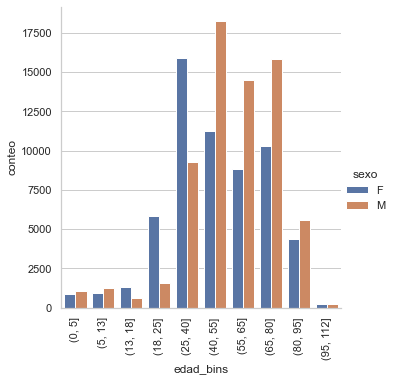

In [139]:
# Gráfica de barras de cantidad de personas por intervalo de edad en cada género
g = sns.catplot(
    data=conteo_edad_x_sexo, kind="bar",
    x="edad_bins", y="conteo", hue="sexo",
)
g.set_xticklabels(rotation=90)
plt.show()

In [144]:
geo_vars = ['ubigeo_inei_domicilio', 'dep_domicilio', 'prov_domicilio', 'dist_domicilio']
df_main[geo_vars].head()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
0,80101,CUSCO,CUSCO,CUSCO
1,150101,LIMA,LIMA,LIMA
2,150801,LIMA,HUAURA,HUACHO
3,140101,LAMBAYEQUE,CHICLAYO,CHICLAYO
4,150101,LIMA,LIMA,LIMA


In [148]:
df_main['ubigeo_inei_domicilio'] = df_main['ubigeo_inei_domicilio'].astype(str)

In [145]:
# Conteo de valores nulos para varias variables
df_main[geo_vars].isna().sum()

ubigeo_inei_domicilio    0
dep_domicilio            0
prov_domicilio           0
dist_domicilio           0
dtype: int64

In [150]:
df_main[geo_vars].describe()

,ubigeo_inei_domicilio,dep_domicilio,prov_domicilio,dist_domicilio
count,136422,136422,136422,136422
unique,1716,25,196,1580
top,150142,LIMA,LIMA,VILLA EL SALVADOR
freq,7156,50719,46309,7156


In [151]:
import geopandas as gpd

In [157]:
gdf_deps = gpd.read_file('../data/LIMITE_DEPARTAMENTAL.zip')
gdf_provs = gpd.read_file('../data/LIMITE_PROVINCIAL.zip')
gdf_dists = gpd.read_file('../data/LIMITE_DISTRITAL.zip')

<AxesSubplot:>

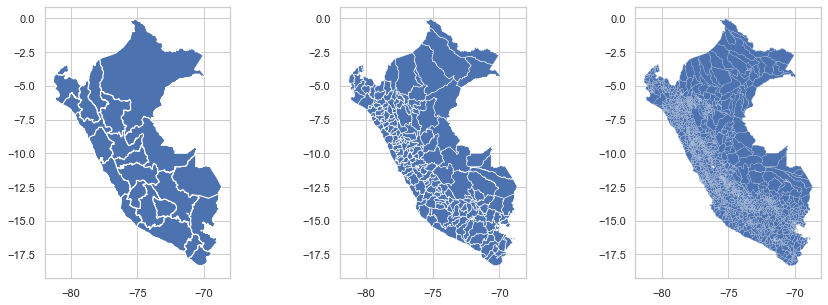

In [163]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                    figsize=(15, 5))

gdf_deps.plot(ax=ax1)
gdf_provs.plot(linewidth=0.5, ax=ax2)
gdf_dists.plot(linewidth=0.1, ax=ax3)

In [174]:
df_unique_dep = df_main['dep_domicilio'].unique()
df_unique_dep.sort()

gdf_unique_dep = gdf_deps['NOMBDEP'].unique()
gdf_unique_dep.sort()

# VALIDAMOS QUE LOS NOMBRES DE DEPARTAMENTOS
# EN LOS DOS DATASETS SEAN IGUALES
(df_unique_dep == gdf_unique_dep).all() # True


In [195]:
# Contamos la cantidad de hospitalizados por departamento
conteo_x_dept = df_main['dep_domicilio'].value_counts()
conteo_x_dept = conteo_x_dept.reset_index()
conteo_x_dept.head()

,index,dep_domicilio
0,LIMA,50719
1,ANCASH,11753
2,CUSCO,10952
3,CAJAMARCA,8584
4,PIURA,7909


In [188]:
# Unimos los conteos utilizando los nombres de departamentos
gdf_conteo_x_dept = pd.merge(left=gdf_deps, right=conteo_x_dept, 
                             left_on="NOMBDEP", right_on='index')

<AxesSubplot:>

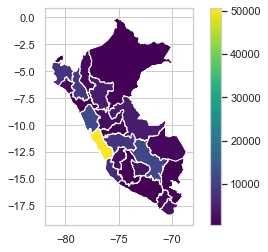

In [194]:
# Mapa de calor de # de hospitalizados x departamento
gdf_conteo_x_dept.plot("dep_domicilio", colormap='viridis',
                       legend=True)